In [1]:
import numpy as np, torch, os, multiprocessing, pandas as pd, sys
import torch.backends.cudnn as cudnn, torchio as tio, random
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
sys.path.append("..")
# from utils.model_res import generate_model

from tqdm import tqdm   

num_workers = multiprocessing.cpu_count()
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cudnn.benchmark = True
random.seed(1234)
torch.manual_seed(1234)

In [2]:
class MLP(nn.Module):
    def __init__(self, num_classes, input_size):
        super(MLP,self).__init__()
        
        self.linear1 = nn.Linear(in_features=input_size, out_features=10)
        self.linear3 = nn.Linear(in_features=10, out_features=num_classes)
        
    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear3(x)
        return x


In [3]:
def norm_one_zero(table):
    import math
    # print(table)
    for i in table:
        if (i in ['age_norm','gender','onset-to-image(datys)','onset-to-ward(days)','nihss_sum_norm','Out_mRS'])==False:
            # print(i)
            cols_filter = [x for x in table[i] if math.isnan(float(x))==False ]
            med = np.median(cols_filter)
            table[i] = [med if math.isnan(float(x))==True else x for x in table[i]]
            min_cols, max_cols =np.min(cols_filter), np.max(cols_filter)

            normal = lambda x: (x - min_cols)/(max_cols - min_cols)
            table[i] = [normal(x) for x in table[i]]
            table[i] = [0 if math.isnan(float(x))==True else x for x in table[i]]
    # print(table)
    return table

csv_path = '../NIHSS_score223.csv'
table_ =  pd.read_csv(csv_path)
print("table_['Out_mRS']", len(table_['Out_mRS']))
# print(table_.columns.values)
table_label = table_.drop(['ID', 'predict (0-2"good", 3-6"bad")', 'age', '發病日期', 
                                                        '有acute MRA/日期 (2wk內)', '病房日期', 'onset-to-image(有acute-發病日期)',
                                                        'onset-to-ward(病房日期-發病日期)', '入院mRS', 'NIHSS  total', '出院mRS'],axis=1)
print("table_label.columns.values", len(table_label.columns.values))
# print(table_label)
nii_3t_train = sorted([i for i in os.listdir(os.path.join('../dataset/S2_data1.5&3.0/'))])

table_label_norm = norm_one_zero(table_label)
X_train, X_test, y_train, y_test = train_test_split(nii_3t_train, table_label_norm,  stratify=list(table_label['Out_mRS']), test_size=0.25, random_state=123) #seed = 42, 123
# print(y_train)
print('train', ' 0: ', len(y_train['Out_mRS'])-sum(y_train['Out_mRS']),'1:',sum(y_train['Out_mRS']))
print('valid', '0: ', len(y_test['Out_mRS'])-sum(y_test['Out_mRS']), '1:',sum(y_test['Out_mRS']))

table_['Out_mRS'] 222
table_label.columns.values 21
train  0:  90 1: 76
valid 0:  30 1: 26


In [4]:
def tio_process(nii_3t_, table_3t_, basepath_='./dataset/S2_data1.5&3.0/'):
    subjects_ = []
    for  (nii_path, nii_table) in zip(nii_3t_ , table_3t_):
        tb_len = nii_table.shape[-1]
        subject = tio.Subject(
            dwi = tio.ScalarImage(os.path.join(basepath_, nii_path)), 
            mRS = int(nii_table[-1]),
            score= nii_table[0:20])
        subjects_.append(subject)
    return subjects_

In [5]:
def S2_evaluate(model,valid_loader):
    predict_array = {'target':[], 'predict':[]}
    model.eval()
    stream_v = tqdm(valid_loader)
    with torch.no_grad():
        for i, data in enumerate(stream_v, start=1):
            # images = data['dwi'][tio.DATA].to(device)
            nihss = data['score'].to(device)
            target = torch.LongTensor(data['mRS']).to(device)
            output = model(nihss.to(torch.float32)).squeeze(1)
            output = torch.sigmoid(output)
            # output = (output - output.min()) / (output.max() - output.min() + 1e-8)
            # print(output)
            # _, outputs = torch.max(output, 1)
            predict_array['predict'].append(np.array(output.cpu()))
            predict_array['target'].append(target.item())
    return predict_array
    
if True:
    test_transform = tio.Compose([])
    S2_weight_stack = '../checkpoint/TEST12.27-01-223_patient_sum_ONLY_NIHSS_score/mRS - 3dresnet18 - lr_0.01 - CEL --  epoch:20 | vLoss:0.36481 | vAcc:86.6667.pt'
    S2_reply = []
    model = MLP(num_classes=2, input_size=20)
    checkpoint = torch.load(S2_weight_stack, map_location=torch.device(device))
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    # //////////////////////////////////////////////////
    validation_subjects = tio_process(X_test, np.array(y_test), basepath_ = '../dataset/S2_data1.5&3.0/')
    validation_set = tio.SubjectsDataset(validation_subjects, transform=test_transform)
    valid_loader = torch.utils.data.DataLoader(validation_set, batch_size=1,  shuffle=False, num_workers=2)
    S2_reply.append(S2_evaluate(model, valid_loader))

100%|██████████| 56/56 [00:26<00:00,  2.09it/s]


In [6]:
pred_table = pd.DataFrame([], columns=['ID', 'Ground Truth', 'Predict 0-3', 'Predict 3-6'])
pred_table

,ID,Ground Truth,Predict 0-3,Predict 3-6


In [7]:
for g,p,d in zip(S2_reply[0]['target'], S2_reply[0]['predict'] , validation_subjects):
    p_0 = p[0][0]
    p_1 = p[0][1]
    ID = d['dwi']['path'].replace('../dataset/S2_data1.5&3.0/','')
    new_user = pd.DataFrame([[ID, g, p_0, p_1]], columns=['ID', 'Ground Truth', 'Predict 0-3', 'Predict 3-6'])
    pred_table = pred_table.append(new_user)

In [8]:
temp = list(pred_table['Predict 3-6']>0.5)
temp = [int(x) for x in temp]
pred_table['Predict_Result'] = temp
# pred_table.to_csv('./Only MRI image - patient222.csv')
pred_table.to_csv('./Only NIHSS Score - patient222.csv')
pred_table.head()

,ID,Ground Truth,Predict 0-3,Predict 3-6,Predict_Result
0,is0317.nii.gz,1,0.381459,0.593892,1
0,is0232.nii.gz,1,0.028079,0.974470,1
0,is0184.nii.gz,0,0.639702,0.268018,0
0,is0265.nii.gz,1,0.065506,0.940215,1
0,is0152.nii.gz,0,0.660560,0.297483,0


In [9]:

GT =np.array(pred_table['Ground Truth'])
SR = np.array(pred_table['Predict_Result'])
TP = int((SR * GT).sum()) #TP
FN = int((GT * (1-SR)).sum()) #FN
TN = int(((1-GT) * (1-SR)).sum()) #TN
FP = int(((1-GT) * SR).sum()) #FP
print(f'Accuracy  :', round((TP + TN)/(TP + TN + FP + FN), 2)*100, '%')
print(f'Sensitivity  :', round(float(TP)/(float(TP+FN) + 1e-6), 5))
print(f'Specificity  :', round(float(TN)/(float(TN+FP) + 1e-6), 5))

Accuracy  : 86.0 %
Sensitivity  : 0.84615
Specificity  : 0.86667


In [10]:
def CI(y_pred, y_true):
    n_bootstraps = 1000
    rng_seed = 42  # control reproducibility
    bootstrapped_scores = []
    rng = np.random.RandomState(rng_seed)
    for i in range(n_bootstraps):
        indices = rng.randint(0, len(y_pred), len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
            continue
        score = roc_auc_score(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    return confidence_lower, confidence_upper

In [11]:
from sklearn import metrics
fpr, tpr, threshold = metrics.roc_curve(np.array(pred_table['Ground Truth']).astype(np.int8), np.array(pred_table['Predict 3-6']))
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc, '[',CI(np.array(pred_table['Predict 3-6']),np.array(pred_table['Ground Truth']).astype(np.int8)),']')

0.9153846153846154 [ (0.8424479166666666, 0.979565772669221) ]


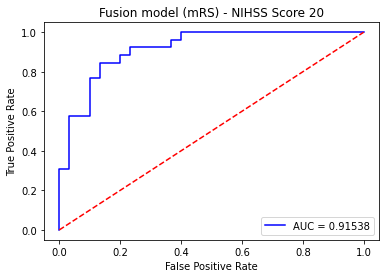

In [12]:
import matplotlib.pyplot as plt
plt.title('Fusion model (mRS) - NIHSS Score 20')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()